y = W2 * ReLU(W1 * X)

SSE loss

Active set for each neuron j

In [1]:
import numpy as np
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm

# Load California Housing dataset
housing = fetch_california_housing()
X = housing.data  # Features
Y = housing.target.reshape(-1, 1)  # Target

# Standardize features
scaler_X = StandardScaler()
X = scaler_X.fit_transform(X)

# Standardize target
scaler_Y = StandardScaler()
Y = scaler_Y.fit_transform(Y)

# Split into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.2, random_state=42
)

# Add bias term
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])

# Parameters
n_samples, n_features = X_train.shape
hidden_dim = 200
output_dim = Y_train.shape[1]
max_iterations = 400  # Maximum number of iterations
delta = 1e-6  # Threshold for early stopping based on MSE change

# Initialize weights
np.random.seed(42)
W1 = np.random.randn(n_features, hidden_dim) * 0.01
W2 = np.random.randn(hidden_dim, output_dim) * 0.01

# Function to compute MSE
def compute_mse(Y_true, Y_pred):
    return np.mean((Y_true - Y_pred) ** 2)

# Function to perform ReLU activation
def relu(Z):
    return np.maximum(0, Z)

# Initialize previous_active_sets outside the loop
previous_active_sets = [np.array([]) for _ in range(hidden_dim)]

train_mse_list = []

# Iterative procedure
for iteration in tqdm(range(max_iterations)):
    # print(f"\nIteration {iteration + 1}/{max_iterations}")

    # Forward pass
    H_train = relu(X_train @ W1)
    Y_pred_train = H_train @ W2
    train_mse = compute_mse(Y_train, Y_pred_train)

    # print(f"Training MSE: {train_mse:.6f}")

    train_mse_list.append(train_mse)

    # Early stopping based on training MSE change over the last 10 iterations
    if iteration >= 10:
        last_10_mse = train_mse_list[-10:]
        mse_changes = np.abs(np.diff(last_10_mse))
        max_change = np.max(mse_changes)
        if max_change < delta:
            print(f"Training MSE did not change more than {delta} in the last 10 iterations.")
            print("Stopping early due to convergence.")
            break

    # Assume active sets have stabilized until proven otherwise
    active_sets_stabilized = True
    stabilized_neurons = 0  # Counter for stabilized neurons

    # Temporary arrays to store updates
    W1_new = np.zeros_like(W1)
    W2_new = np.zeros_like(W2)

    # Update W1 and W2 for each neuron in the hidden layer
    for j in range(hidden_dim):
        # Active set for neuron j
        pre_activation = X_train @ W1[:, j]
        active_indices = np.where(pre_activation > 0)[0]

        # Check if active set has changed
        if not np.array_equal(active_indices, previous_active_sets[j]):
            active_sets_stabilized = False
        else:
            stabilized_neurons += 1  # Active set has not changed

        # Update previous active set
        previous_active_sets[j] = active_indices

        if len(active_indices) == 0:
            # Reinitialize weights for neuron j
            W1_new[:, j] = np.random.randn(n_features) * 0.01
            W2_new[j, :] = np.random.randn(output_dim) * 0.01
            active_sets_stabilized = False  # Active set has changed
            print(f"Reinitialized neuron {j}")
            continue  # Skip further processing for this neuron

        X_active = X_train[active_indices]
        Y_active = Y_train[active_indices]

        # Compute hidden activations excluding neuron j
        H_minus_j = relu(X_active @ W1)
        H_minus_j[:, j] = 0  # Exclude neuron j
        
        # Compute residual
        R_j = Y_active - H_minus_j @ W2

        # Perform SVD on R_j
        U, S, Vt = np.linalg.svd(R_j, full_matrices=False)

        if len(S) == 0:
            # If SVD fails due to insufficient data
            W1_new[:, j] = W1[:, j]
            W2_new[j, :] = W2[j, :]
            continue

        sigma_1 = S[0]
        u_1 = U[:, 0]
        v_1 = Vt[0, :]

        # Update weights
        w2_j_new = v_1 * np.sqrt(sigma_1)
        # Solve for w1_j: X_active @ w1_j = u_1 * sqrt(sigma_1)
        w1_j_new = np.linalg.pinv(X_active) @ (u_1 * np.sqrt(sigma_1))

        W1_new[:, j] = w1_j_new
        W2_new[j, :] = w2_j_new

    # After processing all neurons, update W1 and W2
    W1 = W1_new.copy()
    W2 = W2_new.copy()

    # After updating W1, recompute W2 using all data
    H_train = relu(X_train @ W1)
    # To avoid singular matrix, add a small regularization term
    regularization = 1e-8 * np.eye(H_train.shape[1])
    W2 = np.linalg.pinv(H_train.T @ H_train + regularization) @ H_train.T @ Y_train

    # Print the number of stabilized neurons
    # print(f"Number of stabilized neurons: {stabilized_neurons}/{hidden_dim}")

    # Check for convergence
    if active_sets_stabilized:
        print("Active sets have stabilized. Stopping iterations.")
        break

# Final training and testing MSE
H_train = relu(X_train @ W1)
Y_pred_train = H_train @ W2
final_train_mse = compute_mse(Y_train, Y_pred_train)

H_test = relu(X_test @ W1)
Y_pred_test = H_test @ W2
final_test_mse = compute_mse(Y_test, Y_pred_test)

print("\nFinal Results:")
print(f"Final Training MSE: {final_train_mse:.6f}")
print(f"Final Testing MSE: {final_test_mse:.6f}")

Y_train_unscaled = scaler_Y.inverse_transform(Y_train)
Y_pred_train_unscaled = scaler_Y.inverse_transform(Y_pred_train)

Y_test_unscaled = scaler_Y.inverse_transform(Y_test)
Y_pred_test_unscaled = scaler_Y.inverse_transform(Y_pred_test)

unscaled_train_mse = compute_mse(Y_train_unscaled, Y_pred_train_unscaled)
unscaled_test_mse = compute_mse(Y_test_unscaled, Y_pred_test_unscaled)
print(f"Unscaled Training MSE: {unscaled_train_mse:.6f}")
print(f"Unscaled Testing MSE: {unscaled_test_mse:.6f}")


100%|██████████| 400/400 [05:07<00:00,  1.30it/s]


Final Results:
Final Training MSE: 0.170596
Final Testing MSE: 0.252109
Unscaled Training MSE: 0.227157
Unscaled Testing MSE: 0.335695


[399 398 397 396 395 394 393 392 391 390]
0.1706094424617377
0.1706094424617377


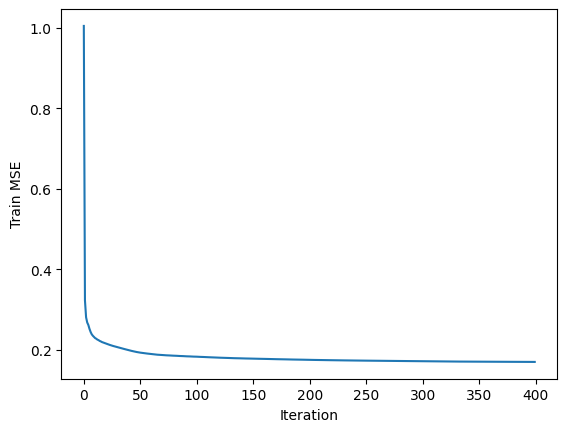

In [2]:
top_10_min_indexes = np.argsort(train_mse_list)[:10]
print(top_10_min_indexes)
print(train_mse_list[top_10_min_indexes[0]])
print(train_mse_list[-1])


import matplotlib.pyplot as plt

plt.plot(train_mse_list)
plt.xlabel("Iteration")
plt.ylabel("Train MSE")
plt.show()

In [3]:
W1

array([[ 0.19687285,  0.33664916,  0.14997562, ..., -0.03867965,
         0.32790294, -0.29957417],
       [ 0.03043484,  0.04188516,  0.02126041, ...,  0.07111054,
         0.04539069, -0.0536311 ],
       [-0.09471712, -0.16533261, -0.02705239, ..., -0.14280919,
        -0.13151223,  0.11922554],
       ...,
       [-0.23027634, -0.36264914, -0.18961887, ...,  0.10066515,
        -0.34205997,  0.28308264],
       [-0.21979344, -0.3511574 , -0.20734755, ...,  0.06851408,
        -0.33348865,  0.27511414],
       [-0.03192858,  0.01385317,  0.01358955, ...,  0.55463834,
         0.00869739,  0.0037241 ]])

In [4]:
W2

array([[ 19.03785007],
       [-28.21428943],
       [ 18.33668991],
       [-25.26951096],
       [ 18.6075472 ],
       [-14.91432694],
       [-11.69396391],
       [-18.67187638],
       [  6.82847041],
       [-42.74117141],
       [ 10.40534856],
       [ 36.73299487],
       [-24.14179546],
       [ 46.32132834],
       [ 18.95026484],
       [ 43.16491795],
       [-22.54886337],
       [ 15.65417471],
       [ 12.44107056],
       [ 19.25358659],
       [ -6.11542561],
       [-22.20114651],
       [ 32.31910754],
       [ 14.33351918],
       [-37.61848048],
       [-25.03022972],
       [-20.022646  ],
       [ 30.29141473],
       [-15.66984819],
       [ 16.33532915],
       [ 28.88355461],
       [ 10.61214118],
       [-10.47639109],
       [ 19.35207249],
       [-11.6942642 ],
       [-13.3377921 ],
       [ 17.68231956],
       [ 22.13220824],
       [-11.87256659],
       [-19.78222191],
       [ 24.7975649 ],
       [-98.7755689 ],
       [-25.7976096 ],
       [-30

In [5]:
train_mse_list[:20]

[np.float64(1.0043928569151301),
 np.float64(0.3233722244790414),
 np.float64(0.2813637090187754),
 np.float64(0.2684607329847263),
 np.float64(0.26229541331322526),
 np.float64(0.25268437500147695),
 np.float64(0.24500711115810825),
 np.float64(0.23916763054193235),
 np.float64(0.23551055017992997),
 np.float64(0.23270160325756933),
 np.float64(0.22975792396505898),
 np.float64(0.2281813178354748),
 np.float64(0.22597376195687854),
 np.float64(0.22475853431332987),
 np.float64(0.22275007014901463),
 np.float64(0.2215578036575625),
 np.float64(0.2199542991683131),
 np.float64(0.21889443253481072),
 np.float64(0.21756270124005497),
 np.float64(0.21670493672932342)]